In [ ]:
#Install Transformer
pip install transformers

In [224]:
# And pandas for data import
import pandas as pd

In [225]:
# Import Files
import os

# Import data from csv
data = pd.read_csv("/tmp/tamil_offensive_full_train.csv")
data_dev = pd.read_csv("/tmp/tamil_offensive_full_dev.csv")

# Select required columns
data = data[['comment', 'class_type']]
data_dev = data_dev[['comment', 'class_type']]

# Remove a row if any of the three remaining columns are missing
data = data.dropna();
data_dev = data_dev.dropna()

print(data)
print(data_dev)

                                                 comment                           class_type
0                      movie vara level la Erika poguthu                        Not_offensive
1      I love Ajith Kumar Vivegam movie inki mjy bht ...                            not-Tamil
2              Padam nalla comedy padama irukum polaye..                        Not_offensive
3      karthick subburaj anne .... intha padam vetri ...                        Not_offensive
4      கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁                        Not_offensive
...                                                  ...                                  ...
35134  Trending number #2 idhukku nammalam karanamnu ...                        Not_offensive
35135                                 Movie script super   athuvum HIP HOP Tamizha music vera
35136                       Just 3k likes for 300k likes                        Not_offensive
35137                          Aaloo le lo. Kanda le lo.    

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,14,16,17,18,20,21,22,23,24,25,26,27,28,29,32,35,37,39,45,57,58) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [226]:
# copy + klearn because you allways need sklearn
import copy
from sklearn.model_selection import train_test_split

In [253]:
# Remove rows, where the label is present only ones (can't be split)
data = data.groupby('class_type').filter(lambda x : len(x) > 1)
data_dev = data_dev.groupby('class_type').filter(lambda x : len(x) > 1)

# Remove rows, where the label is present only in the array
data = data[data.class_type.isin(['Not_offensive', 'Offensive_Targeted_Insult_Other', 'Offensive_Targeted_Insult_Individual', 'Offensive_Targeted_Insult_Group', 'not_Tamil', 'Offensive_Untargetede'])]
data_dev = data_dev[data_dev.class_type.isin(['Not_offensive', 'Offensive_Targeted_Insult_Other', 'Offensive_Targeted_Insult_Individual', 'Offensive_Targeted_Insult_Group', 'not_Tamil', 'Offensive_Untargetede'])]

# Set your model output as categorical and save in new label col
data['class_type_label'] = pd.Categorical(data['class_type'])
data_dev['class_type_label'] = pd.Categorical(data_dev['class_type'])

# Transform your output to numeric
data['class_type'] = data['class_type_label'].cat.codes
data_dev['class_type'] = data_dev['class_type_label'].cat.codes

print(data)
print(data_dev)

(0, 3)


,comment,class_type,class_type_label


In [228]:
# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
from tensorflow.keras.models import Model

In [229]:
#Setup BERT

# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [230]:
# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.initializers import TruncatedNormal

In [231]:
#Build the model 

# Load the MainLayer
bert = transformer_model.layers[0]

# Max length of tokens
max_length = 100

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
class_type = Dense(units=len(data.class_type_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='class_type')(pooled_output)
outputs = {'class_type': class_type}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

Model: "BERT_MultiLabel_MultiClass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
__________________________________________________________________________________________________
pooled_output (Dropout)         (None, 768)          0           bert[0][

In [232]:
#Import Keras Libraries
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [233]:
#Train the model

# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = {'class_type': CategoricalCrossentropy(from_logits = True)}
metric = {'class_type': CategoricalAccuracy('accuracy')}

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Ready output data for the model
y_class_type = to_categorical(data['class_type'])

# Tokenize the input (takes some time)
x = tokenizer(
    text=data['comment'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},
    y={'class_type': y_class_type},
    validation_split=0.2,
    batch_size=64,
    epochs=10)

model.save("/tmp/text-classification.h5")

Epoch 1/10
387/387 [==============================] - 545s 1s/step - loss: 0.7891 - accuracy: 0.7549 - val_loss: 0.6563 - val_accuracy: 0.7768
Epoch 2/10
387/387 [==============================] - 526s 1s/step - loss: 0.6367 - accuracy: 0.7721 - val_loss: 0.6494 - val_accuracy: 0.7812
Epoch 3/10
387/387 [==============================] - 526s 1s/step - loss: 0.5881 - accuracy: 0.7857 - val_loss: 0.6475 - val_accuracy: 0.7844
Epoch 4/10
387/387 [==============================] - 526s 1s/step - loss: 0.5594 - accuracy: 0.7957 - val_loss: 0.7169 - val_accuracy: 0.7913
Epoch 5/10
387/387 [==============================] - 525s 1s/step - loss: 0.5092 - accuracy: 0.8128 - val_loss: 0.6607 - val_accuracy: 0.7800
Epoch 6/10
387/387 [==============================] - 525s 1s/step - loss: 0.4928 - accuracy: 0.8237 - val_loss: 0.6993 - val_accuracy: 0.7870
Epoch 7/10
387/387 [==============================] - 525s 1s/step - loss: 0.4770 - accuracy: 0.8262 - val_loss: 0.7031 - val_accuracy: 0.7863

In [234]:
#Evaluate the model

# Ready test data
test_y_class_type = to_categorical(data_dev['class_type'])
test_x = tokenizer(
    text=data_dev['comment'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids'], 'attention_mask': test_x['attention_mask']},
    y={'class_type': test_y_class_type}
)

121/121 [==============================] - 29s 237ms/step - loss: 0.7462 - accuracy: 0.7802


In [235]:
#History object
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

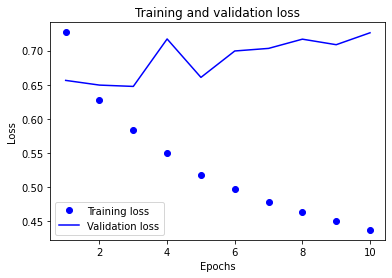

In [236]:
#plot the training and validation loss for comparison
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

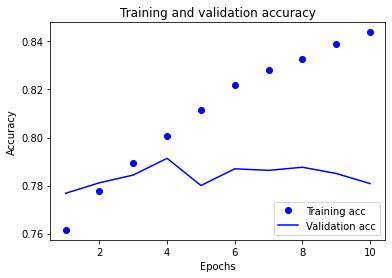

In [237]:
#plot the training and validation accuracy for comparison
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [238]:
#Model Prediction
data_test = pd.read_csv("/tmp/tamil_offensive_full_test.csv")

# Select required columns
data_test = data_test[['comment']]

# Remove a row if any of the three remaining columns are missing
data_test = data_test.dropna()

test_x = tokenizer(
    text=data_test['comment'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

predict = model.predict({'input_ids': test_x['input_ids'], 'attention_mask': test_x['attention_mask']})
  

In [240]:
print(predict)

{'class_type': array([[ 5.2709346 , -1.0836084 , -1.5631858 , -1.7603798 , -0.5391249 ],
       [ 4.170054  , -1.4295857 , -1.2600068 , -1.8537989 ,  0.18805404],
       [ 4.0169992 , -1.3208134 , -0.33630058, -1.8156922 , -0.5803839 ],
       ...,
       [-0.4220343 ,  0.37807497, -0.6001418 , -0.96860796,  1.9103626 ],
       [ 5.4198194 , -0.8767448 , -1.013413  , -1.6343588 , -1.598137  ],
       [ 4.744748  , -0.97667736, -0.85140777, -1.7997695 , -0.9284616 ]],
      dtype=float32)}


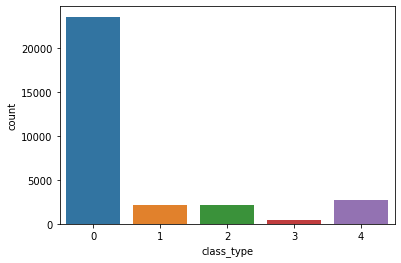

In [245]:
#Plot the bar chart of Train
import seaborn as sns

sns.countplot(x='class_type', data=data)

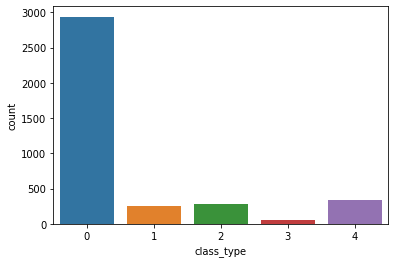

In [249]:
#Plot the bar chart of Dev
sns.countplot(x='class_type', data=data_dev)